# Trabajo de programación Nº 2
## LFIS419 - Inteligencia Artificial


## Identificación del (de los) Estudiante(s):
<table>
<tr>
<th> Nombre </th>
<th> RUT </th>
<th> email </th>
</tr>
<tr>
<td> Fabian Trigo </td>
<td> 20.183.107-5 </td>
<td> fabian.trigo@alumnos.uv.cl </td>
</tr>
</table>

## Instrucciones específicas
En este trabajo exploraremos un dataset usado previamente con técnicas de machine learning y obtenido desde https://www.kaggle.com/datasets/uciml/iris?resource=download (visitado el 19 de abril de 2023). Revisar la descripción de estos datos en la página original.


El objetivo es usar Random Forest y SVM para clasificar la especie de flore en dependencia de algunas de sus características.

In [2]:
# imports del notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

import sklearn.svm as svm #support vecotr machine library
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
random_state = 42

# cargar los datos
iris = pd.read_csv("Iris.csv")
# el id comienza en 0, sera molesto usarlo asi que lo eliminaremos
iris = iris.drop('Id', axis=1)

iris.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Actividad 1: Análisis previo y pre-proceso

a) Analice las variables de entrada al modelo, identificado cuales de ellas tienen una alta correlación (entre ellas y/o con la clase a la que corresponden).


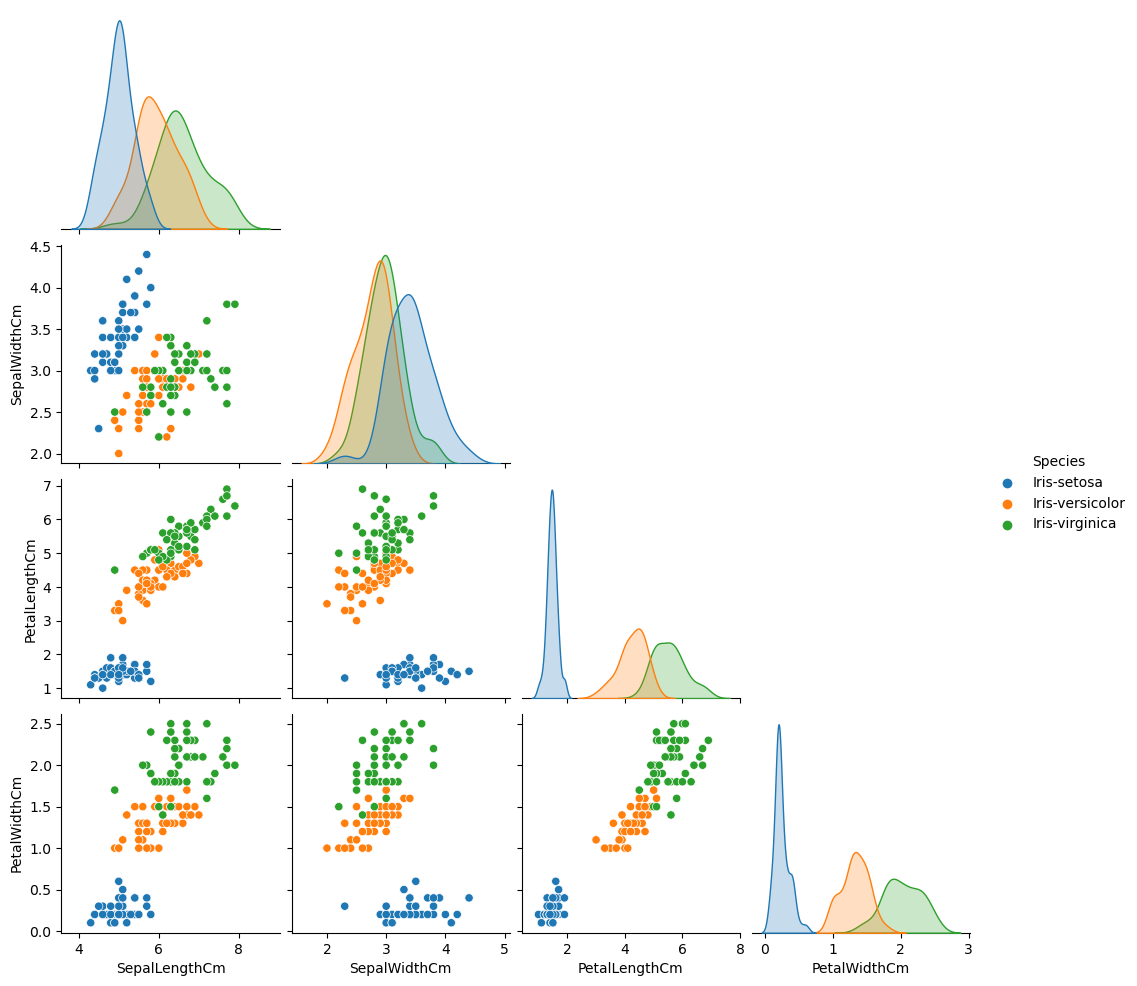

In [3]:
# todas las variables:
pairplot = sns.pairplot(iris, corner=True, hue='Species')
plt.show()

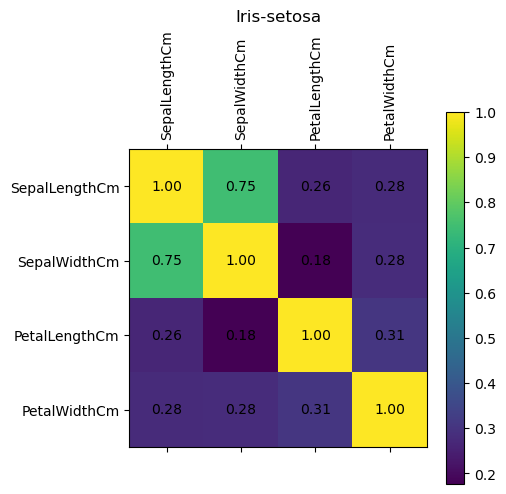

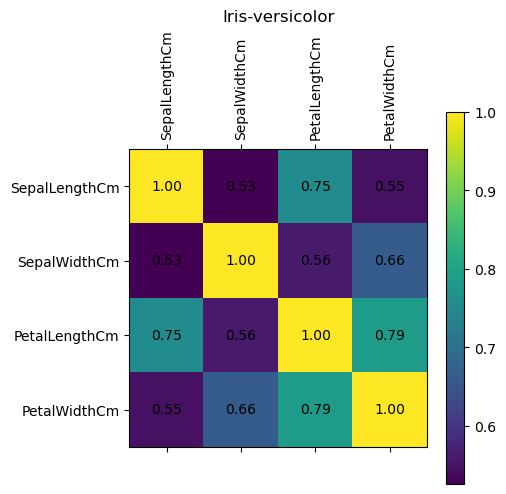

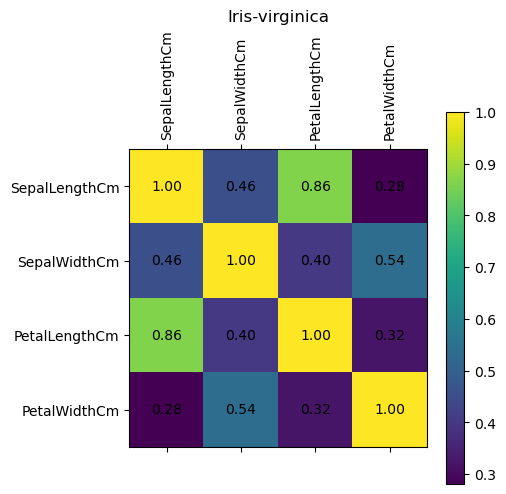

In [4]:
# correlation plot =========
# nos permitira observar relaciones entre las variables

especies = iris["Species"].unique()
for especie in especies:
    # matrix de correlacion 
    corr_matrix = iris[  iris["Species"] == especie].corr(method='pearson')
    plt.matshow(corr_matrix)

    # agrego los valores dentro de cada cuadrado para mejor visualizacion
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center')

    #agrego informacion al grafico
    plt.colorbar()
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.title(f"{especie}")
    plt.show()

observamos asi que variables se relacionan mucho entre ellas, cosas como el tamaño de los petalos y el sepalo.

Podemos observar que en otras especies existe otra correlación


b) Prepare las variables para que puedan ser procesadas tanto por Random Forest como por Support Vector Machine.


In [5]:
print(f"especies: {especies}")

# veamos los tipos de datos
print("\ntipos de datos")
print(iris.dtypes)

especies: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

tipos de datos
SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species           object
dtype: object


In [6]:
especies

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [7]:
# para ello creo un diccionario
especies_numeros = {v: k for k, v in list(enumerate(especies))}
print(especies_numeros)

# mapeo de los valores
iris['Species'] = iris['Species'].map(especies_numeros)

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}


In [8]:
# se encuentran asi los datos en mejor formato
print("\ntipos de datos")
print(iris.dtypes)

iris.head()


tipos de datos
SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species            int64
dtype: object


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


c) Divida el conjunto en 3 subconjuntos para entrenamiento, validación y testeo. Verifique si la distribución de los 3 conjuntos es similar.

In [9]:
# separamos la informacion
X = iris.drop('Species', axis=1)
y = iris['Species']

# entrenamiento (60%), validacion (20%), testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

# Print shapes of the resulting sets
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (90, 4)
X_val shape: (30, 4)
X_test shape: (30, 4)
y_train shape: (90,)
y_val shape: (30,)
y_test shape: (30,)


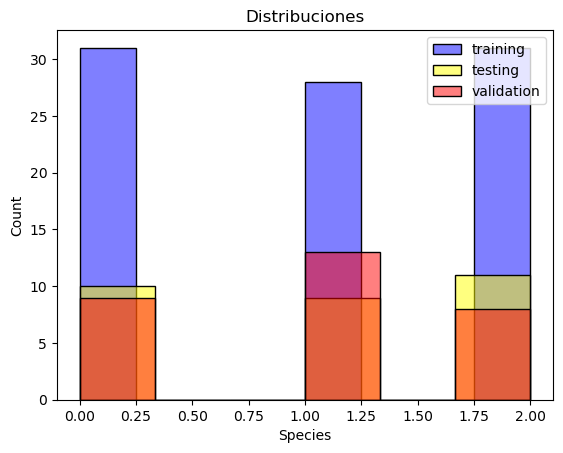

In [10]:
sns.histplot(y_train, label="training", color="blue", alpha=0.5, multiple="dodge")
sns.histplot(y_test, label="testing", color="yellow", alpha=0.5, multiple="dodge")
sns.histplot(y_val, label="validation", color="red", alpha=0.5, multiple="dodge")

plt.title("Distribuciones")
plt.legend()
plt.show()

# es de gran importancia que el training posea una disrtribucion uniforme

es importante verificar que la distribucion de los subconjuntos es similar, para que el training sea equitativo


In [12]:
# opcionalmente se puede guardar el csv actualizado
iris.to_csv("Iris_clean.csv")

## Actividad 2: Random Forest
Recordemos
- training
- validation
- testing (final step)

In [15]:
# imports del notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
random_state = 42

# puede usar el iris si ha seguido el modelo hasta ahora
# o importar el archivo exportado previamente
# iris = pd.read_csv("Iris_clean.csv")


# Generamos los datos del training:
X = iris.drop('Species', axis=1)
y = iris['Species']

# entrenamiento (60%), validacion (20%), testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)


a) Desarrolle un modelo para clasificar la especie de flor en base a las características entregadas, utilizando random forest. 

b) Entrene usando el subconjunto de entrenamiento y evalúe su rendimiento sólo con el subconjunto de validación. 

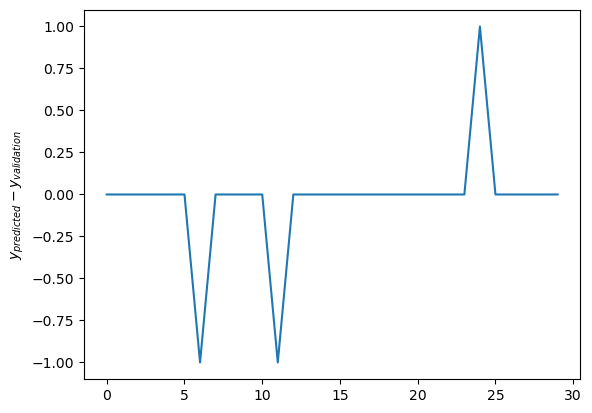

In [41]:
modelo_rf = RandomForestClassifier() # instanciar
modelo_rf.fit(X_train.values, y_train.values) # entrenar

# prediccion
y_validation_predicted = modelo_rf.predict(X_val.values)

# plotting de la diferencia
plt.plot(y_val.values - y_validation_predicted)
plt.ylabel(r"$y_{predicted} - y_{validation}$")
plt.show()

In [40]:
# podemos ver su score:
training_score = modelo_rf.score(X_train.values, y_train)
validation_score = modelo_rf.score(X_val.values, y_val)

print(f"Puntaje de entrenamiento: {training_score * 100} %")
print(f"Puntaje de validacion: {validation_score * 100} %")

Puntaje de entrenamiento: 100.0 %
Puntaje de validacion: 96.66666666666667 %


como vemos obtenemos buen puntaje de entrenamiento, pues es lo esperado si son datos que ya conoce; y la validación va bastante bien

c) Optimice los hiperparámetros para conseguir un "buen modelo".

In [61]:
from sklearn.model_selection import GridSearchCV

modelo_search = RandomForestClassifier()
# parametros a probar:
param_grid = {
    'n_estimators': [100 * x for x in range(1,4)],
    'max_depth': [x for x in range(5,30)],
    'min_samples_split': [2*x for x in range(1,5)]
}

# instanciamos un objeto de gridsearch
# cv=5 es 5 fold-cross-validation
grid_search = GridSearchCV(estimator=modelo_search, 
    param_grid=param_grid, cv=5, n_jobs=3)

# realiza el fit, pero por detras utiliza las combinaciones de parametros
grid_search.fit(X_train.values, y_train.values)

# entrega los mejores hiperparametros
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9444444444444443


Es posible guardar estos parametros y utilizarlos para crear una nueva instancia:

```python
modelo_mejorado = RandomForestClassifier(grid_search.best_params_)
```

unque el grid_search se comporta como un objeto `modelo`, con los metodos de predicción y testing

In [79]:
testing_score = grid_search.score(X_test.values, y_test.values)
validation_score = grid_search.score(X_val.values, y_val.values)

print(f"Puntaje de testing {testing_score * 100} %")

Puntaje de testing 100.0 %


In [80]:
# no haremos más training, asi que:
print("Finalmente, el modelo esta listo:")
print(f"Puntaje de validacion {validation_score * 100} %")
print("_________________________________________________")

Finalmente, el modelo esta listo:
Puntaje de validacion 93.33333333333333 %
_________________________________________________


## Actividad 3: Support Vector Machine
Desarrolle un modelo para clasificar la especie de flor en base a las características entregadas, utilizando SVM. Entrene usando todos los datos excepto los del conjunto de testeo, pero utilizando una validación cruzada k-fold. 

Pruebe al menos 3 kernel diferentes y algunos de sus parámetros (mínimo 10 entrenamientos diferentes) y determine el mejor modelo (dentro de los que usted probó).

## Kernels de SVC
Kernel lineal
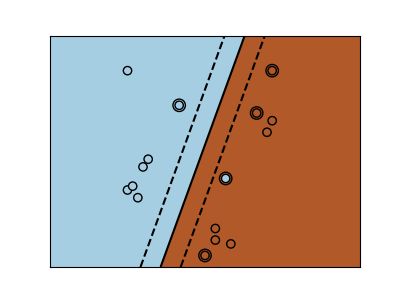

Kernel Polinomial
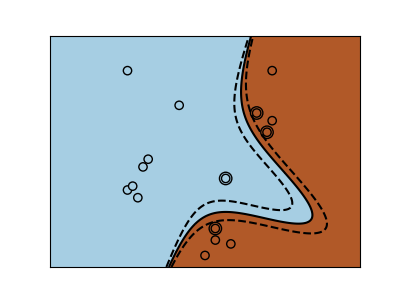

Kernel RBF
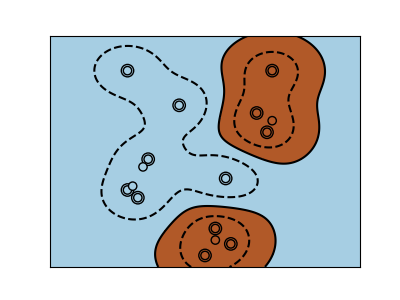



Justifique las decisiones tomadas.

In [70]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
random_state = 42

# realizamos el split de los datos
X = iris.drop('Species', axis=1)
y = iris['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# aqui podemos instanciar un modelo y ver que parametros toma
svm.SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Un poco de descripcion sobre los parametros a utilizar:
- `kernel`: "nucleo función" que se encarga de separar, si es lineal veremos una linea que separa los datos
- `degree`: afecta a los polinomiales, el grado del polinomio
- `gamma`: Como escalar coeficientes, $scale \Rightarrow \frac{1}{n_{features} * \mathbb V[x]}$, $auto \Rightarrow \frac{1}{n_{features}}$
- `coef0`: agrega un coeficiente a los polinomios

In [83]:
param_grid = {
    "C": [1.0, 2.0, 3.0, 4.0],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [2, 3, 4, 5, 6],
    "gamma": ["auto", "scale"],
    "coef0": [0, 0.5, 1.0, 1.5, 2.0],
}

# n_jobs es la cantidad de procesadores a utilzar, 
# es muy util poder paralelizar este proceso
svc_grid_search = GridSearchCV(estimator=svm.SVC(), 
    param_grid=param_grid, cv=5, n_jobs=6)

# realiza el fit, pero por detras utiliza las combinaciones de parametros
svc_grid_search.fit(X_train.values, y_train.values)

# entrega los mejores hiperparametros
print(f"Best Hyperparameters: {svc_grid_search.best_params_}")
print(f"Best Score: {svc_grid_search.best_score_}")

Best Hyperparameters: {'C': 3.0, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
Best Score: 0.9666666666666668


In [84]:
# Aqui usamos los testing como validacion
svc_validation_score = svc_grid_search.score(X_test.values, y_test.values)

# no haremos más training, asi que:
print("Finalmente, el modelo esta listo:")
print(f"Puntaje de validacion {svc_validation_score * 100} %")
print("_________________________________________________")

Finalmente, el modelo esta listo:
Puntaje de validacion 100.0 %
_________________________________________________


Puede ser que por suerte obtuvieramos este 100%, si se quiere realizar un testing más a fondo, deberiamos volver a la parte de entrenamiento y realizar K-folds; pero para quedarse en el contexto de la pregunta de separar datos y testear, a probabilidad obtuvimos este resultado;

asi que más adelante compararemos usando el promedio, osea utilizando el score de todos los datos a disposición, para comparar este modelo y el de arboles aleatorios.

## Actividad 4:
Compare el rendimiento de los modelos de Random Forest y Support Vector Machine. Discuta las posibles razones para las diferencias.

In [85]:
# no haremos más training, asi que:

mean_forest_score = grid_search.score(X.values, y.values)
mean_svc_score = svc_grid_search.score(X.values, y.values)


print("Finalmente, el modelo esta listo:")

print(f"Puntaje de RandomTreeClassifier: {validation_score * 100} %")
print(f"Puntaje de SVC: {svc_validation_score * 100} %")

print("_________________________________________________")

Finalmente, el modelo esta listo:
Puntaje de RandomTreeClassifier: 93.33333333333333 %
Puntaje de SVC: 100.0 %
_________________________________________________


Para conversar sobre la eficacia de los modelos, haremos una breve visualizacion con estos parametros y datos aleatorios.
El resultado no tiene relevancia, pero es un ejemplo en terminos conceptuales

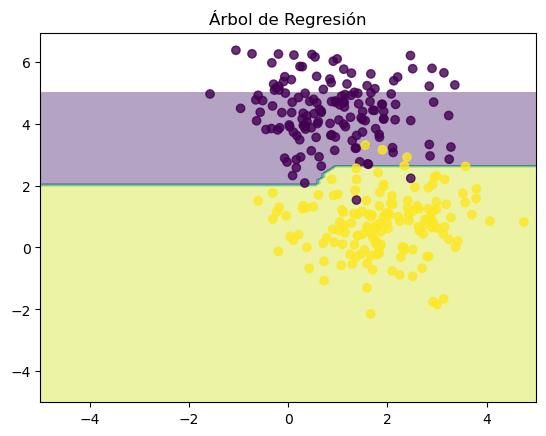

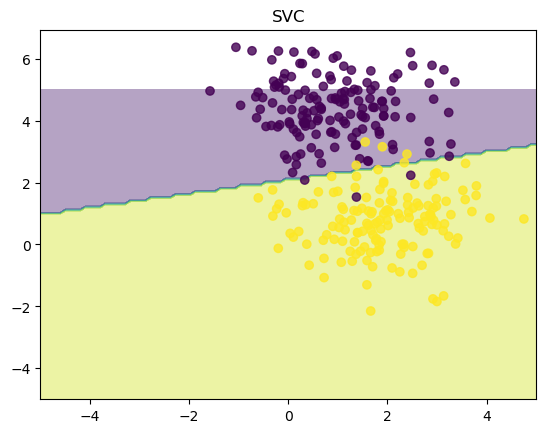

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


# Crear datos aleatorios con make_blobs
X, y = make_blobs(n_samples=300, centers=2, n_features=2, random_state=0)

# comparemos los dos modelos con los parametros
reg_tree = RandomForestClassifier(**grid_search.best_params_)
svc = svm.SVC(**svc_grid_search.best_params_)

# por cuestion de visualizacion los entrenamos con datos 2D
reg_tree.fit(X,y)
svc.fit(X,y)

# Crear una malla de puntos para graficar los límites de decisión
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
Z_reg_tree = reg_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z_svc = svc.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Graficar los límites de decisión y los puntos de datos
plt.contourf(xx, yy, Z_reg_tree, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.title('Árbol de Regresión')
plt.show()

plt.contourf(xx, yy, Z_svc, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.title('SVC')
plt.show()


# Arbol de decision:
Separa en cuadrantes, realizando separaciones con bloques; resulta algo debil en el caso de tener datos mezclados, osea tipos de datas similares como lo son las especies de flores.

# SVC
Support Vector Machine, el hecho de tener libertad con los kernel nos ayuda a separar no linealidades, osea que funciona mejor en el caso de tener datos similares.

## Conclusion
Se puede observar en la imagen que si bien un arbol de decision separo mayor cantidad de dato correctamente, lo que esta aprendiendo es el ruido; osea que es un modelo más facil de sobre ajustar; por tanto tendra mejor training pero peor etapa de validacion.

En cambio el SVC radica mejor en separar zonas en lugar de preocuparse por puntos individuales, al buscar separar con lineas es capaz de generalizar mejor.

